DOWNLOAD DATA<br>
Boiler plate code to download images 

In [30]:
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
import zipfile

train_path = 'train'
dl_file = 'dl2018-image-proj.zip'
dl_url = 'https://users.aalto.fi/mvsjober/misc/'

zip_path = os.path.join(train_path, dl_file)
if not os.path.isfile(zip_path):
    download_url(dl_url + dl_file, root=train_path, filename=dl_file, md5=None)

with zipfile.ZipFile(zip_path) as zip_f:
    zip_f.extractall(train_path)
    #os.unlink(zip_path)

KeyboardInterrupt: 

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#FAST AI LIBRARIES
from fastai import *
from fastai.vision import *

#OTHER LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import PIL

# workaround 
from PIL import Image
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
  for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions


print(PIL.PILLOW_VERSION)

5.3.0


Setting Training Path

In [6]:
PATH = "train/images/"

Displaying Image functions

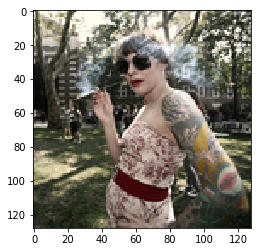

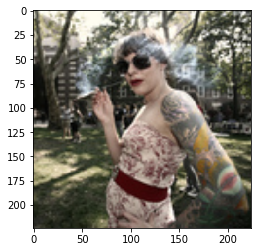

In [7]:
img=mpimg.imread(f'{PATH}/im1.jpg')
imgplot = plt.imshow(img)
plt.show()

im = cv2.imread(f'{PATH}/im1.jpg')
im_resized = cv2.resize(im, (224, 224), interpolation=cv2.INTER_LINEAR)
plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
plt.show()

# Data Analysis and Pre-processing

In [8]:
# check all the classes

from os import listdir
from os.path import isfile, join
classes = [f[:-4] for f in listdir('train/annotations/') if isfile(join('train/annotations/', f))]

In [9]:
classes

['baby',
 'bird',
 'car',
 'clouds',
 'dog',
 'female',
 'flower',
 'male',
 'night',
 'people',
 'portrait',
 'river',
 'sea',
 'tree']

In [10]:
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

In [11]:
# distribution of the classes
path='train/annotations/'

dist = dict([(f'{f[:-4]}',file_len(f'{path}{f}')) for f in listdir(path) if isfile(join(path, f))])
            
            

In [12]:
dist

{'baby': 95,
 'bird': 360,
 'car': 319,
 'clouds': 1095,
 'dog': 448,
 'female': 3227,
 'flower': 761,
 'male': 2979,
 'night': 598,
 'people': 6403,
 'portrait': 3121,
 'river': 120,
 'sea': 173,
 'tree': 525}

<BarContainer object of 14 artists>

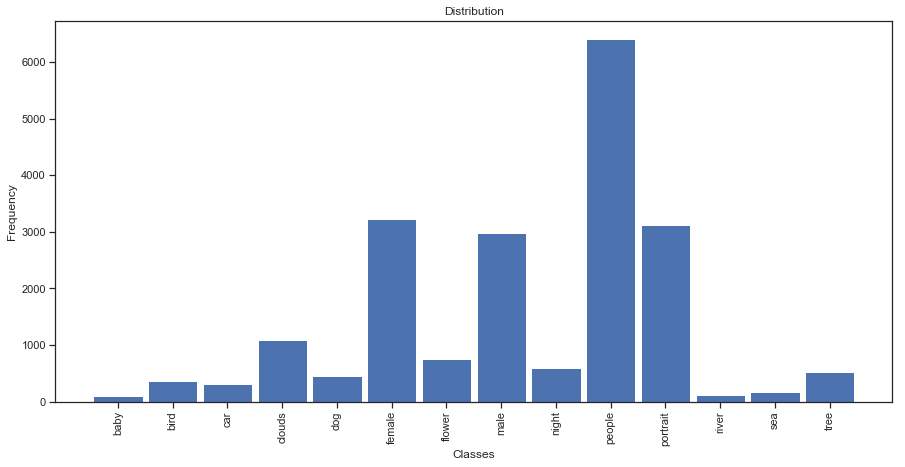

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
plt.figure(figsize=(15,7))
plt.xticks(rotation=90)
plt.ylabel("Frequency")
plt.xlabel("Classes")
plt.title(f"Distribution")
plt.bar(dist.keys(), dist.values(), width=0.9, color='b')

The dataset is imbalanced

In [71]:
# sort all the images from im1....imn
file_col = listdir("train/images")
list1 = [int(x[2:len(x)-4]) for x in file_col if x[0]=='i']
list1.sort()
listfin = ["train/images/im"+str(num)+".jpg" for num in list1]

file_col = pd.Series(listfin)

# creation of the dataframe 
df = pd.DataFrame()
df["fileName"] = file_col

path = "train/annotations"

row = 0

# file dic contains how many samples there are for each class. Is it needed?
file_dic = {}

for label, filename in enumerate(listdir(path)):
  # array of zeros (20000,) that will be one column of the df
  tmp = np.zeros(file_col.shape[0], dtype=int)
  with open(path+"/"+filename, "r") as file:
    file_len = 0
    for line in file:
      # get the line that contains that image
      line = line.replace("\n", "")
      line = int(line)
      tmp[line-1] = 1   # set 1 for the image that contains that class 
      file_len = file_len + 1
  filename = filename[:-4]
  tmp = pd.Series(tmp)
  df[filename] = tmp
  file_dic[filename] = file_len

print(file_dic)

{'baby': 95, 'bird': 360, 'car': 319, 'clouds': 1095, 'dog': 448, 'female': 3227, 'flower': 761, 'male': 2979, 'night': 598, 'people': 6403, 'portrait': 3121, 'river': 120, 'sea': 173, 'tree': 525}


In [73]:
for k in df.columns[1:]:print(k)

baby
bird
car
clouds
dog
female
flower
male
night
people
portrait
river
sea
tree


In [74]:
def vec2label (df):
  l = []
  for i in range(df.shape[0]):
    p = []
    for k in df.columns[1:]:
      if df.iloc[i][f'{k}']:
        p.append(k)
    l.append(p)
  l = pd.Series(l)
  return l

df['classes']= vec2label(df)

0              [female, people, portrait]
1                                      []
2                                      []
3                          [male, people]
4                          [male, people]
5                                      []
6                        [female, people]
7                                      []
8                                      []
9                                      []
10                         [male, people]
11             [female, people, portrait]
12                                 [male]
13                                     []
14                         [clouds, tree]
15                        [night, people]
16                                     []
17                                     []
18                                     []
19                                     []
20                               [clouds]
21                                     []
22                                     []
23                         [male, 

In [76]:
mask = df['classes'].astype(str) == '[]' 
missing_values = sum(mask)
print("missing values:", missing_values)

# percentage of images without class
print((missing_values/20000)*100)

missing values: 9824
49.120000000000005


In [77]:
# delete all the values without target
df = df[~mask]
df.head()

,fileName,baby,bird,car,clouds,dog,female,flower,male,night,people,portrait,river,sea,tree,classes
0,train/images/im1.jpg,0,0,0,0,0,1,0,0,0,1,1,0,0,0,"[female, people, portrait]"
3,train/images/im4.jpg,0,0,0,0,0,0,0,1,0,1,0,0,0,0,"[male, people]"
4,train/images/im5.jpg,0,0,0,0,0,0,0,1,0,1,0,0,0,0,"[male, people]"
6,train/images/im7.jpg,0,0,0,0,0,1,0,0,0,1,0,0,0,0,"[female, people]"
10,train/images/im11.jpg,0,0,0,0,0,0,0,1,0,1,0,0,0,0,"[male, people]"


In [79]:
df.to_csv("data.csv")

In [80]:
df.head()

,fileName,baby,bird,car,clouds,dog,female,flower,male,night,people,portrait,river,sea,tree,classes
0,train/images/im1.jpg,0,0,0,0,0,1,0,0,0,1,1,0,0,0,"[female, people, portrait]"
3,train/images/im4.jpg,0,0,0,0,0,0,0,1,0,1,0,0,0,0,"[male, people]"
4,train/images/im5.jpg,0,0,0,0,0,0,0,1,0,1,0,0,0,0,"[male, people]"
6,train/images/im7.jpg,0,0,0,0,0,1,0,0,0,1,0,0,0,0,"[female, people]"
10,train/images/im11.jpg,0,0,0,0,0,0,0,1,0,1,0,0,0,0,"[male, people]"


In [81]:
def dataformatter(df,out=None):
    op = df
    op['img'] = df['fileName'].apply(lambda x: x[13:-4])
    op['tags'] = df.iloc[:,15]
    op['tags'] = df['tags'].apply(lambda x: ' '.join(str(p) for p in x))
    op=op[['img','tags']]
    print(op.head())
    op.to_csv(f'{out}.csv', header=False,index=False)

dataformatter(df,out='labels')

     img                    tags
0    im1  female people portrait
3    im4             male people
4    im5             male people
6    im7           female people
10  im11             male people


In [82]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.1)

test_data.to_csv('./test.csv')
train_data.to_csv('./train.csv')

dataformatter(train_data,out='train')
dataformatter(test_data,out='test')

C:\Users\samsa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\samsa\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\samsa\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

           img                    tags
3367    im3368  female people portrait
14403  im14404             male people
620      im621                   night
321      im322    male people portrait
1027    im1028        male people tree
           img                  tags
17959  im17960  male people portrait
17050  im17051                 river
7520    im7521                flower
10110  im10111                people
311      im312            people sea


In [83]:
torch.cuda.is_available()

True

In [84]:
PATH = '.'

In [85]:
!dir {PATH}

 Volume in drive D is DATA
 Volume Serial Number is 5612-169F

 Directory of D:\KZ\Projects\Deep-Learning-Project-UH18

04/01/2019  23.54    <DIR>          .
04/01/2019  23.54    <DIR>          ..
02/01/2019  05.22    <DIR>          .git
31/12/2018  13.09               180 .gitignore
02/01/2019  23.40    <DIR>          .ipynb_checkpoints
04/01/2019  23.54           818 163 data.csv
03/01/2019  18.28           519 730 Deep_Learning_Project_DATA_PROCESSING.ipynb
02/01/2019  04.59           546 477 Deep_Learning_Project_DATA_PROCESSING_prove.ipynb
04/01/2019  23.54         1 856 177 Deep_Learning_Project_FASTAI.ipynb
31/12/2018  22.05        70 274 086 dl2018-image-test.zip
31/12/2018  13.09           415 290 ImageProject.ipynb
23/11/2017  11.19    <DIR>          images
04/01/2019  23.54           222 075 labels.csv
04/01/2019  23.36    <DIR>          models
31/12/2018  13.09               183 README.md
31/12/2018  13.09    <DIR>          report
04/01/2019  23.36           212 031 results

In [86]:
tfms = get_transforms(do_flip=True,flip_vert=True, max_zoom=1.05, max_warp=0.,max_rotate=25)
data = (ImageItemList.from_csv(PATH, 'labels.csv',sep=' ', folder='train\images', suffix='.jpg')
        .random_split_by_pct()
        .label_from_df(sep=' ')
        .transform(tfms, size=128)
        .databunch(bs=64)
        .normalize(imagenet_stats))

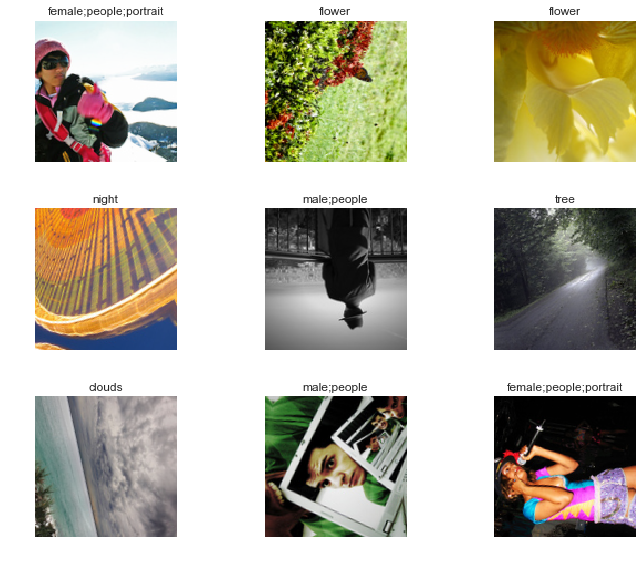

In [87]:
data.show_batch(rows=3, figsize=(10,8))


# TRAINING


In [88]:
learn = create_cnn(data, models.resnet18, metrics=fbeta)
learn.fit_one_cycle(10,max_lr=slice(1e-03,1e-01))

epoch,train_loss,valid_loss,fbeta
1,0.228291,0.175842,0.777766
2,0.222036,0.215129,0.753722
3,0.291028,0.243809,0.728426
4,0.256615,0.506909,0.760426
5,0.246851,0.274584,0.763092
6,0.217218,0.540157,0.772562
7,0.203642,0.167775,0.782290
8,0.189068,0.230895,0.788181
9,0.173777,0.369421,0.794703
10,0.167994,0.179178,0.798384


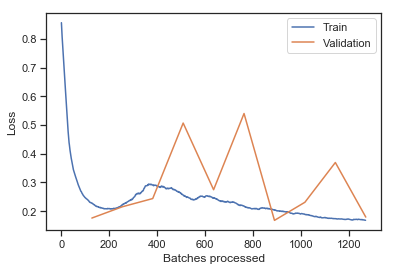

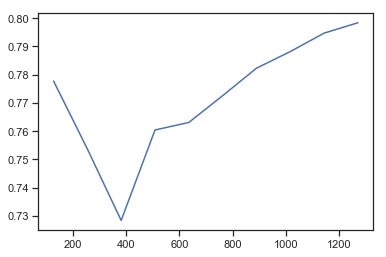

In [89]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


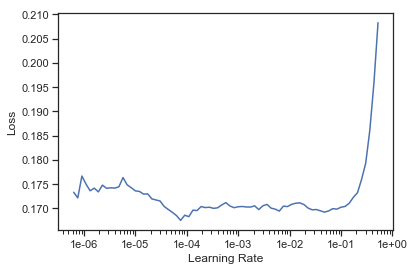

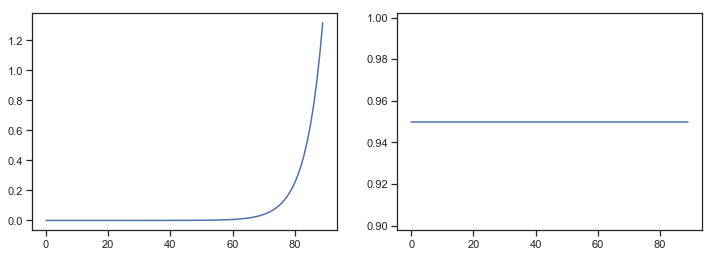

In [90]:
learn.lr_find()
learn.recorder.plot()
learn.recorder.plot_lr(show_moms=True)

In [91]:
learn.save('dlcompetition_resnet18')

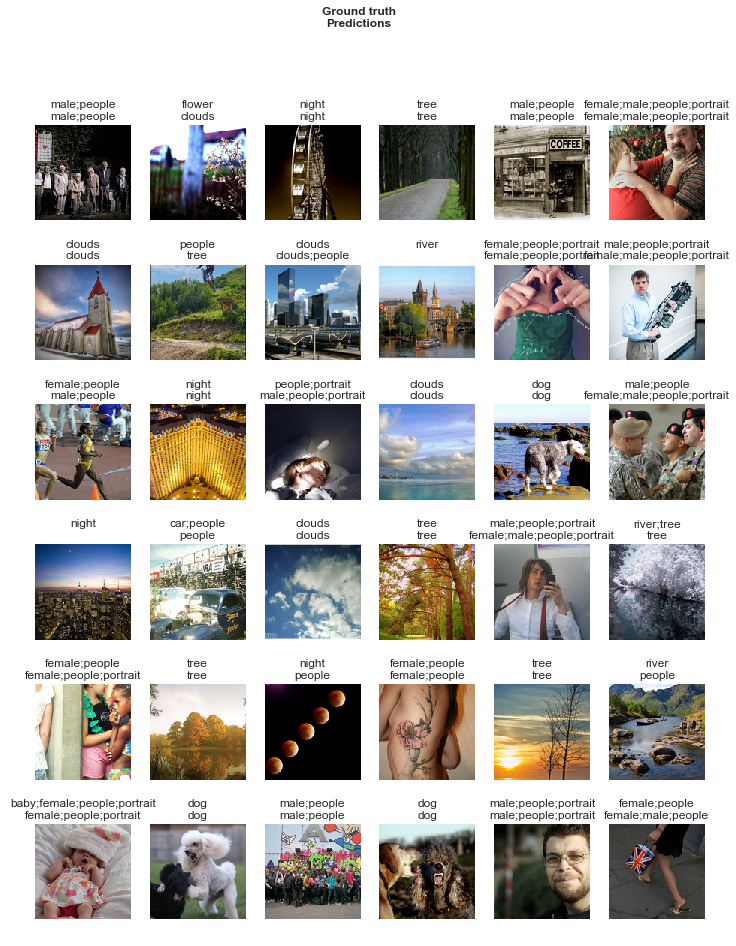

In [92]:
learn.show_results(rows=6, figsize=(12,15))


# INFERENCE


In [93]:
learn = create_cnn(data, models.resnet18).load('dlcompetition_resnet18')


In [94]:
data_test = ImageItemList.from_folder('test/images')


In [ ]:
preds,y = learn.get_preds(data_test)


In [52]:
np.savetxt('results.txt', y, fmt='%d')

In [53]:
len(classes)

14

In [54]:
print(data.classes)
len(data.classes),data.c

['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea']


(13, 13)